In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
!pip install catboost

In [32]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Manipulation
import pandas as pd
import numpy as np
from statsmodels import robust
from scipy import stats
from scipy.stats import uniform, randint

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV

# Evaluation
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             roc_auc_score, confusion_matrix, precision_recall_curve)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Data Analysis

In [33]:
df = pd.read_csv("/content/drive/MyDrive/Projetos/Air Quality/updated_pollution_dataset.csv")

In [34]:
df.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good


In [35]:
print(f"O dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.")

O dataset possui 5000 linhas e 10 colunas.


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


O primeiro ponto a se observar é a variavel target "Air Quality", que está no formato object, e que vamos precisar converter em uma variável numérica.

In [37]:
# Avaliacao de dados nulos
print(f"Quantidade de dados nulos no dataset:\n{df.isna().sum()}")

Quantidade de dados nulos no dataset:
Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64


In [38]:
# Avaliacao de dados duplicados
print(f"Quantidade de dados duplicados no dataset:\n{df.duplicated().sum()}")

Quantidade de dados duplicados no dataset:
0


In [39]:
df.describe()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,30.029020,70.056120,20.142140,30.218360,26.412100,10.014820,1.500354,8.425400,497.423800
std,6.720661,15.863577,24.554546,27.349199,8.895356,6.750303,0.546027,3.610944,152.754084
min,13.400000,36.000000,0.000000,-0.200000,7.400000,-6.200000,0.650000,2.500000,188.000000
25%,25.100000,58.300000,4.600000,12.300000,20.100000,5.100000,1.030000,5.400000,381.000000
50%,29.000000,69.800000,12.000000,21.700000,25.300000,8.000000,1.410000,7.900000,494.000000
75%,34.000000,80.300000,26.100000,38.100000,31.900000,13.725000,1.840000,11.100000,600.000000
max,58.600000,128.100000,295.000000,315.800000,64.900000,44.900000,3.720000,25.800000,957.000000


Aqui, podemos observar que existe uma discrepância entre os valores das variáveis preditoras. Dessa forma, será necessário aplicar alguma padronização ou normalização nesses dados para que alguns modelos possam ter uma boa performance.

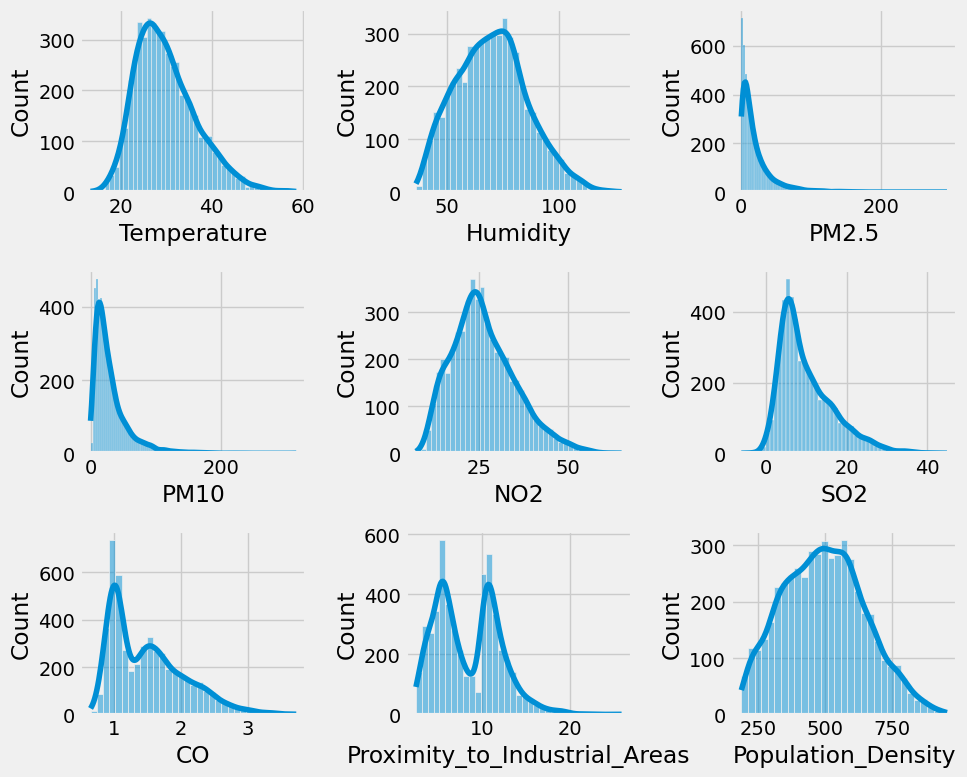

In [40]:
# Verificação da distribuição dos dados
fig, ax = plt.subplots(3, 3, figsize=(10, 8))
ax = ax.flatten()
i = 0

for col in df.columns:
  if(col != "Air Quality"):
    sns.histplot(data=df, x=col, ax=ax[i], kde=True)
    i += 1
plt.tight_layout()
plt.show();

__Temperature e Humidity__: Analisando os gráficos destas duas variáveis, podemos observar que ambas se aproximam de uma normal. Isso indica que, tanto para temperatura, quanto pra umidade, seus valores tem uma oscilação que giram em torno de um valor médio.

__PM2.5 e PM10__: Analisando os gráficos destas duas variáveis, é possível notar que ambas possuem seus valores mais concentrados à esquerda (níveis baixos de PM2.5 e PM10), mas também possuem uma longa cauda à direita onde se encontram valores mais elevados. Essa causa indica que, embora a maior parte da concentração de PM2.5 e PM10 sejam baixas, existem momentos onde a concentração é bastante alta. Mais pra frente iremos analisar a presença de outliers para essas variáveis.

__NO2__: Analisando o gráfico desta variável, podemos observar que também se aproxima de uma normal. Que, da mesma forma como Temperature e Humidity, indica que seus valores oscilam em torno de um valor médio.

__SO2__: Analisando o gráfico desta variável, é possível observar que a maior parte dos dados se concentra em valores menores, mas também podemos notar que existe uma assimetria à direita, indicando que existe a presença de concentrações mais altas de SO2.

__CO__: Analisando o gráfico desta variável, podemos observar que ela aparenta ser um distribuição bimodal, pois existem dois picos.

__Proximity_to_Industrial_Areas__: Neste gráfico, podemos observar que também é uma distribuição bimodal, com dois picos distintos.

__Population_Density__: Neste gráfico, é possível observar uma distribuição que se aproxima de uma normal, mas com alguma assimetria à direita.

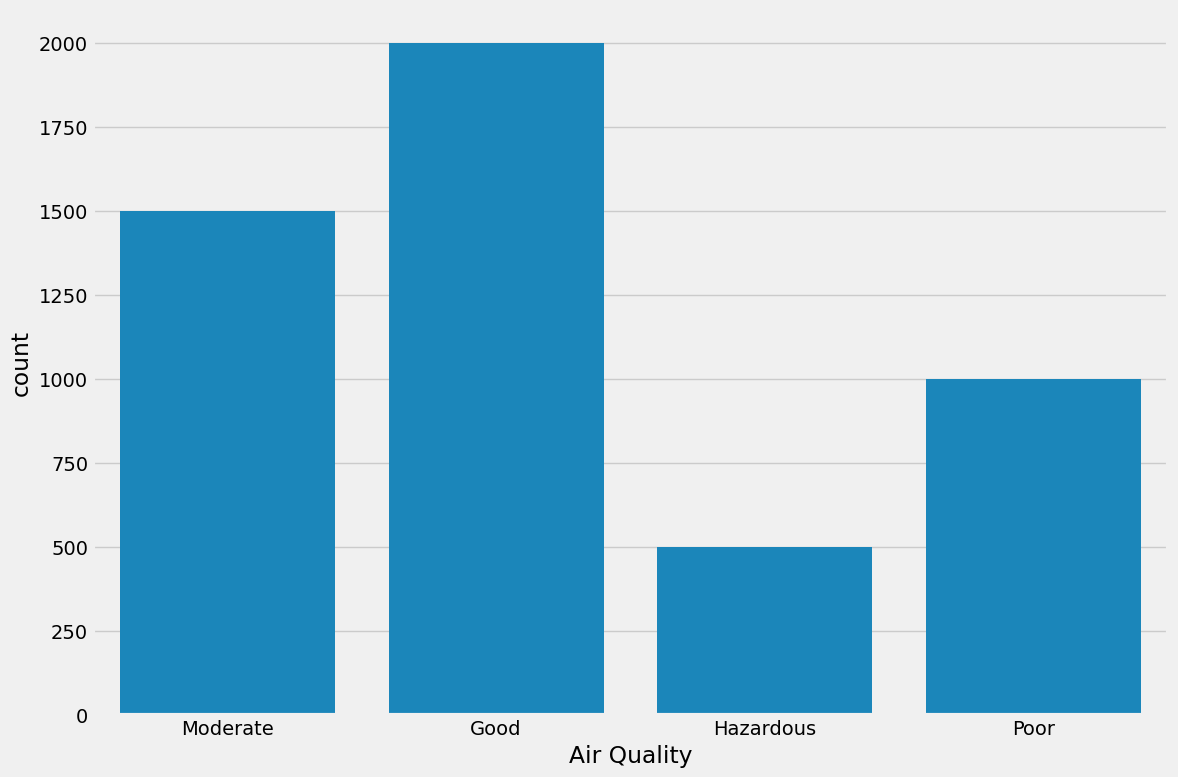

In [41]:
# Verificação da variável alvo
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(data=df, x='Air Quality', ax=ax)
plt.tight_layout()
plt.show();

Analisando a nossa variável alvo, podemos observar que existe algum desbalanceamento entre as classes. Esse desbalanceamento é forte principalmente entre a classe Good (2000 amostras) e a classe Hazardous (500) amostras, o que é uma proporção de 4:1.

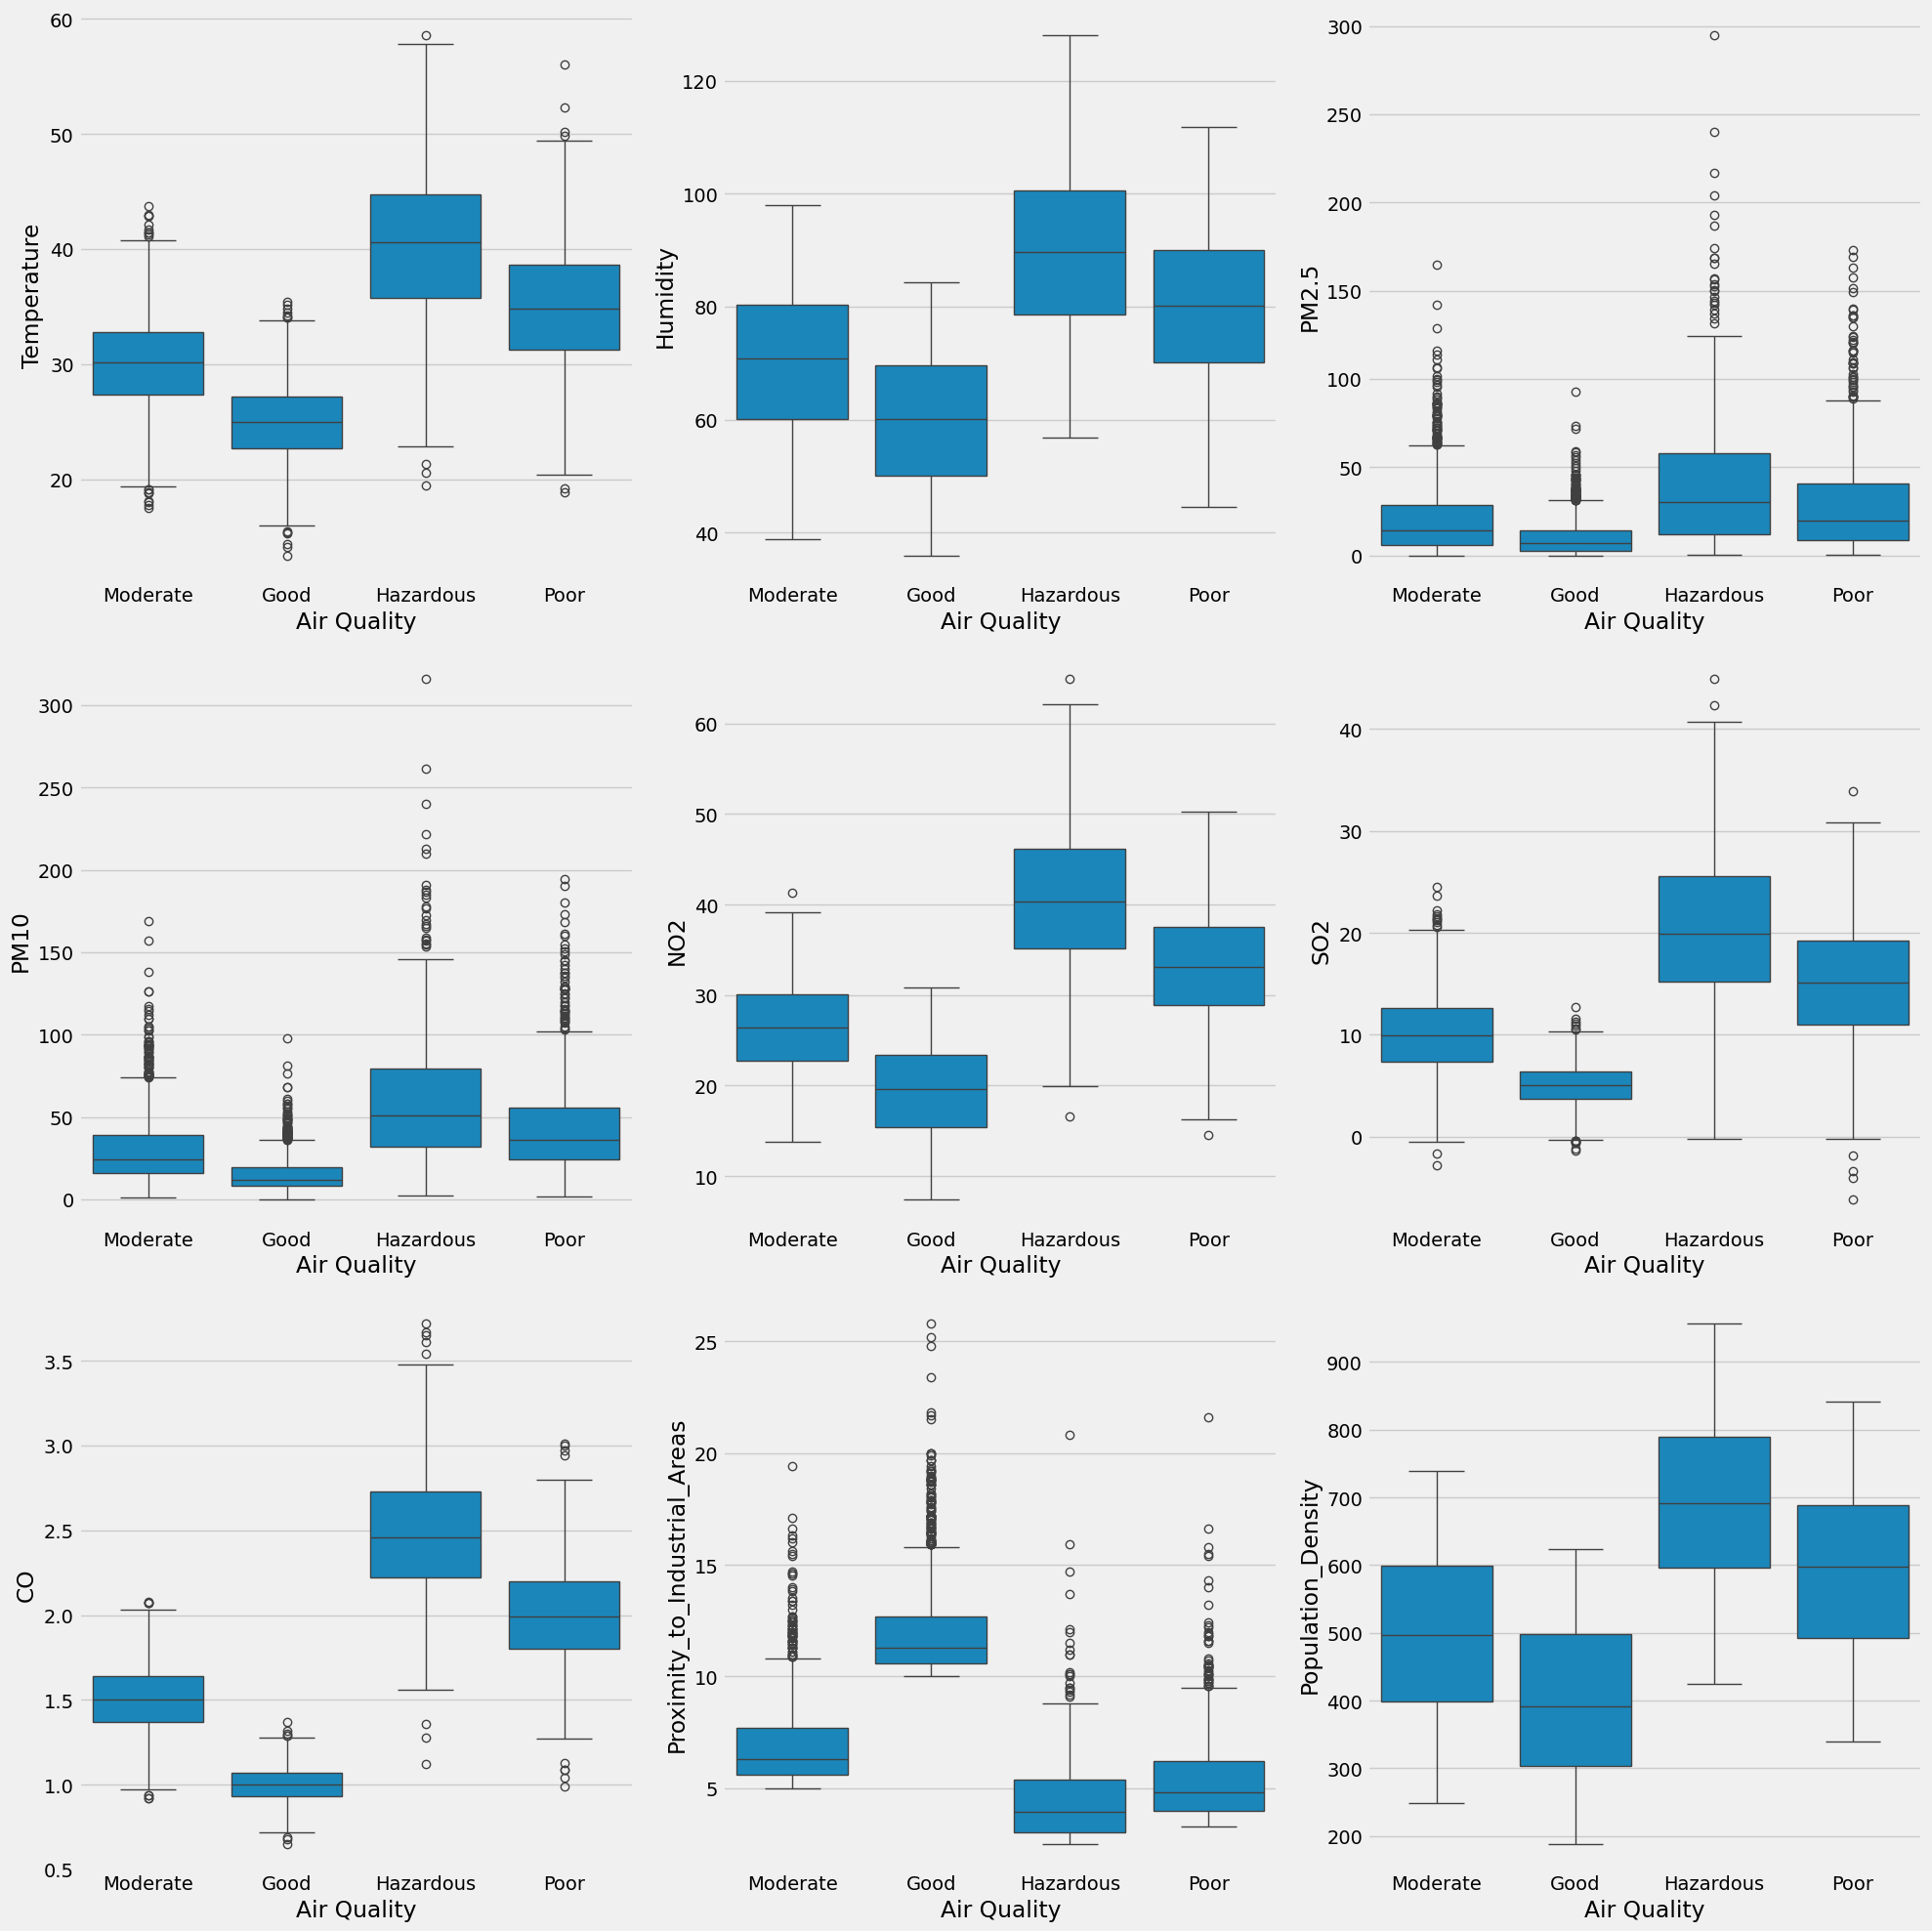

In [42]:
# Verificação da relação entre "Air Quality" e as variáveis preditoras
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
ax = ax.flatten()
i = 0

cols = df.drop(columns=['Air Quality'])
for col in cols:
  sns.boxplot(data=df, x='Air Quality', y=col, ax=ax[i])
  i += 1

plt.tight_layout()
plt.show();

__Temperature x Air Quality__: É possível observar alguns pontos aqui. Primeiro, independetemente da classe, podemos notar a presença de outliers. Segundo, podemos notar que a classe Good apresenta, em média, temperaturas um pouco mais baixas. Já as classes Moderate, Hazardous e Poor apresentam temperaturas mais altas. Podemos observar também que a classe Hazardous apresenta uma variação maior em torno da mediana, pois apresenta maior amplitude interquartil.

__Humidity x Air Quality__: Nesta comparação, podemos observar que não existe a presença de outliers. Também é possível notar que a classe Good parece estar associada a menores níveis de umidade, enquanto que as classes Moderate, Hazardous e Poor parecem estar associadas a maiores níveis de umidade. Outro ponto interessante de ressaltar é que até 50% dos dados observados na classe Good possuem uma umidade de até 60, enquanto que na variável Moderate 75% dos dados apresentados apresentam uma umidade de pelo menos 60.

__PM 2.5 e PM10 x Air Quality__: O primeiro ponto a se observar é a forte presença de outliers para todas as classes. Novamente observamos que, para a classe Good, os níveis de PM 2.5 e de PM10 são mais baixos em comparação aos níveis para as demais classes. Ainda analisando a classe Good, ela apresenta intervalos interquartis mais estreitos, indicando uma menor variabilidade dos dados em torno da mediana. Já as demais classes, em especial a classe Hazardous, o gráfico ,,mostra intervalos interquartis mais amplos, o que indica maior variabilidade dos dados em torno da mediana.

__NO2__: Novamente é possível observar que a classe Good possui menores níveis de NO2 e não possui presença de outliers. Já ao observar as demais classes, podemos notar que existem maiores níveis de NO2, assim como existe a presença de outliers. Um ponto importante a ressaltar é entre a classe Hazardous e Poor, onde para a classe Poor 75% das observações possuem uma concentração de NO2 de algo um pouco abaixo de 40, enquanto que para a classe Hazardous 75% das observações possuem valores acima de algo em torno de 35 de concentração de NO2.

__SO2__: Podemos ver que existem alguns outliers em todas as classes. Um ponto que chama a atenção novamente é a baixa concentração de SO2 quando a classe é Good, onde praticamente todos os dados possuem uma concentração de SO2 de até 10, enquanto que para a classe Moderate 50% dos dados possuem uma concentração de SO2 de até 10 e os outros 50% acima disto. Ainda observando a classe Good, podemos notar que existe pouca variação de valores. Já quando comparamos Hazardous e Poor, é possível notar que a classe Hazardous possui uma mediana superior a todas as outras classes, e também podemos notar que até 50% dos dados possuem uma mediana de até 20 SO2 aproximadamente, enquanto que para a classe Poor até 75% dos dados possui uma concentração de até 18 SO2 aproximadamente.

__CO__: É possível notar que, novamente, todas as classes possuem alguns outliers. Outro padrão que se repete é a baixa concentração para a classe Good e uma relação entre a variável Air Quality e a concentração do gás. Olhando mais para a classe Good, podemos notar que existe pouca variação em torno da mediana, e também que sua concentração mais alta não chega a 1.5 de CO. Já quando olhamos para a classe Moderate, podemos ver que 75% dos dados possuem pelo menos 1.3 (aproximadamente) de concentração de CO. Quando olhamos para as classes Poor e Hazardous, esses níveis ficam ainda mais alarmantes.

__Proximity_to_Industrial_Areas__: Analisando essa relação, podemos ver claramente que quantop mais distante de zonas industriais, mais é a qualidade do ar, o que faz bastante sentido. Podemos ver que existe uma presença grande de outliers para todas as classes. Um ponto interessante é que, para a classe Good, a area industrial mais próxima está a 10km de distância, enquanto que para a classe Hazardous, 75% dos dados estão a aproximadamente 6km de distância de áreas industriais.

__Population_Density__: Neste gráfico não possuímos a presença de outliers. Outro ponto interessante que esse gráfico indica é que quanto menor a densidade populacional, maior é a qualidade do ar.

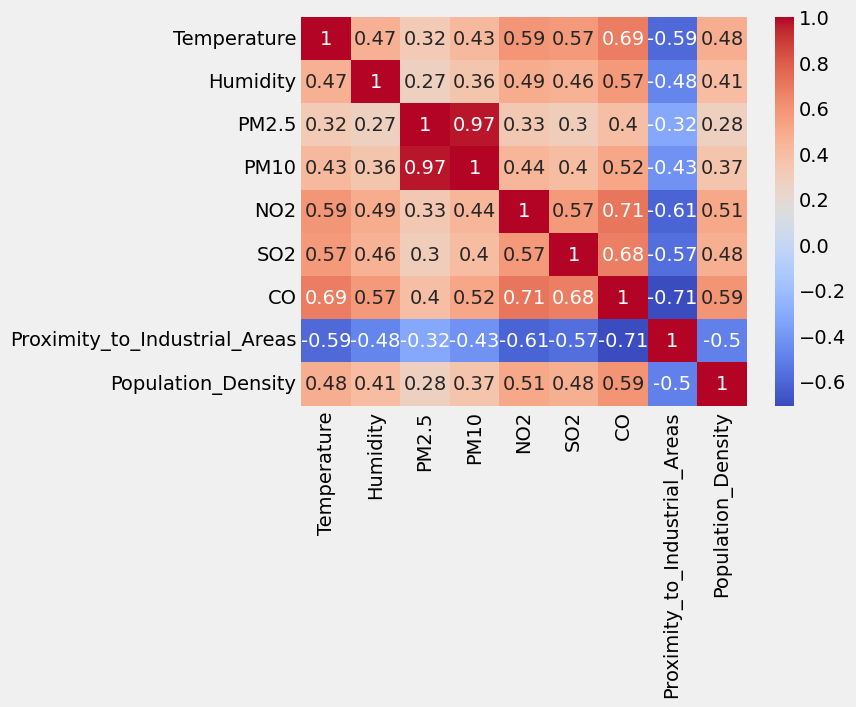

In [43]:
# Verificação da correlação entre as variáveis
sns.heatmap(df.drop('Air Quality', axis=1).corr(), annot=True, cmap='coolwarm')
plt.show();

# Data Preprocessing

In [44]:
# Vamos começar aplicando LabelEncoder na nossa variável alvo.
le = LabelEncoder()
df['Air Quality'] = le.fit_transform(df['Air Quality'])

In [45]:
df['Air Quality'].value_counts()

,count
Air Quality,
0,2000
2,1500
3,1000
1,500


In [46]:
df['Air Quality'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 5000 entries, 0 to 4999
Series name: Air Quality
Non-Null Count  Dtype
--------------  -----
5000 non-null   int64
dtypes: int64(1)
memory usage: 39.2 KB


In [47]:
df.drop('PM10', axis=1, inplace=True)

In [48]:
# Remocao dos outliers

colunas = ['Temperature', 'PM2.5', 'NO2', 'SO2', 'CO', 'Proximity_to_Industrial_Areas', 'Population_Density']

Q1 = df[colunas].quantile(.25)
Q3 = df[colunas].quantile(.75)
IQR = Q3 - Q1

limite_superior = Q3 + 1.5 * IQR
limite_inferior = Q1 - 1.5 * IQR

mask = (df[colunas] >= limite_inferior) & (df[colunas] <= limite_superior)

df_sem_outliers = df[mask.all(axis=1)].copy()

In [49]:
# Aplicacao do StandardScaler

colunas = ['Temperature', 'Humidity', 'PM2.5', 'NO2', 'SO2', 'CO', 'Proximity_to_Industrial_Areas', 'Population_Density']

scaler = StandardScaler()
df_sem_outliers[colunas] = scaler.fit_transform(df_sem_outliers[colunas])

## Split dos dados

In [50]:
X = df_sem_outliers.drop('Air Quality', axis=1)
y = df_sem_outliers['Air Quality']

In [51]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=.2, shuffle=True, random_state=42)

In [52]:
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Parâmetros para teste

In [53]:
params_grid = {
    "Logistic Regression": {
        "model__C": uniform(0.01, 10),
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs", "newton-cg", "sag", "saga"]
    },
    "KNN": {
        "model__n_neighbors": randint(1, 10),
        "model__weights": ["uniform", "distance"],
        "model__metric": ["euclidean", "manhattan", "minkowski"]
    },
    "Gaussian NB": {
    },
    "SVC": {
        "model__C": uniform(0.01, 10),
        "model__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "model__gamma": ["rbf", "poly", "sigmoid"]
    },
    "Decision Tree": {
        "model__max_depth": np.arange(1, 21, 1),
        "model__min_samples_split": np.arange(2, 21, 1),
        "model__min_samples_leaf": np.arange(2, 21, 1),
        "model__criterion": ["gini", "entropy"]
    },
    "Random Forest": {
        "model__n_estimators": randint(100, 500),
        "model__max_depth": np.arange(1, 21, 1),
        "model__min_samples_split": np.arange(2, 21, 1)
    },
    "Gradient Boosting": {
        "model__n_estimators": randint(100, 500),
        "model__learning_rate": [0.2, 0.1, 0.05, 0.01, 0.001],
        "model__max_depth": np.arange(1, 21, 1),
        "model__min_samples_split": np.arange(2, 21, 1),
        "model__min_samples_leaf": np.arange(2, 21, 1)
    },
    "LightGBM": {
        "model__n_estimators": randint(100, 500),
        "model__learning_rate": [0.2, 0.1, 0.05, 0.01, 0.001],
        "model__num_leaves": np.arange(2, 11, 1),
        "model__max_depth": np.arange(1, 21, 1)
    },
    "CatBoost": {
        "model__iterations": randint(100, 500),
        "model__learning_rate": [0.2, 0.1, 0.05, 0.01, 0.001],
        "model__depth": np.arange(1, 11, 1),
        "model__l2_leaf_reg": np.arange(1, 11, 1)
    },
    "XGBoost": {
        "model__n_estimators": randint(100, 500),
        "model__learning_rate": [0.2, 0.1, 0.05, 0.01, 0.001],
        "model__max_depth": np.arange(1, 21, 1),
        "model__min_child_weight": np.arange(1, 11, 1),
    }
}

In [54]:
# Criação dos pipelines

pipelines = {
    "Logistic Regression": Pipeline([
        ("model", LogisticRegression())
    ]),
    "KNN": Pipeline([
        ("model", KNeighborsClassifier())
    ]),
    "Gaussian NB": Pipeline([
        ("model", GaussianNB())
    ]),
    # "SVC": Pipeline([
    #     ("model", SVC())
    # ]),
    "Decision Tree": Pipeline([
        ("model", DecisionTreeClassifier())
    ]),
    "Random Forest": Pipeline([
        ("model", RandomForestClassifier())
    ]),
    "Gradient Boosting": Pipeline([
        ("model", GradientBoostingClassifier())
    ]),
    "LightGBM": Pipeline([
        ("model", LGBMClassifier())
    ]),
    "CatBoost": Pipeline([
        ("model", CatBoostClassifier())
    ]),
    "XGBoost": Pipeline([
        ("model", XGBClassifier())
    ])
}

## Construção dos modelos

In [55]:
best_models = {}

for model_name, pipeline in pipelines.items():
  print(f"Treinando {model_name}...")
  param_grid = params_grid.get(model_name, {})
  search = RandomizedSearchCV(
      pipeline,
      param_distributions=param_grid,
      n_iter=50,
      scoring="accuracy",
      cv=strat_kfold,
      random_state=42,
      n_jobs=-1
  )

  search.fit(X_tr, y_tr)
  best_models[model_name] = search
  print(f"Melhor acurácia: {search.best_score_}")
  print(f"Melhores parâmetros: {search.best_params_}")
  print(f"{model_name} treinado com sucesso!")

Treinando Logistic Regression...
Melhor acurácia: 0.9413564035837025
Melhores parâmetros: {'model__C': 0.35388521115218396, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Logistic Regression treinado com sucesso!
Treinando KNN...
Melhor acurácia: 0.9334595442897158
Melhores parâmetros: {'model__metric': 'manhattan', 'model__n_neighbors': 7, 'model__weights': 'uniform'}
KNN treinado com sucesso!
Treinando Gaussian NB...
Melhor acurácia: 0.9489699835117902
Melhores parâmetros: {}
Gaussian NB treinado com sucesso!
Treinando Decision Tree...
Melhor acurácia: 0.9385410914003058
Melhores parâmetros: {'model__min_samples_split': 19, 'model__min_samples_leaf': 10, 'model__max_depth': 18, 'model__criterion': 'entropy'}
Decision Tree treinado com sucesso!
Treinando Random Forest...
Melhor acurácia: 0.962499056397624
Melhores parâmetros: {'model__max_depth': 13, 'model__min_samples_split': 10, 'model__n_estimators': 256}
Random Forest treinado com sucesso!
Treinando Gradient Boosting...
Me

In [56]:
print("\nAvaliação no conjunto de teste:")
for model_name, search in best_models.items():
    print(f"\nModelo: {model_name}")
    print(f"Melhores hiperparâmetros: {search.best_params_}")
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_ts)
    acc = accuracy_score(y_ts, y_pred)
    print(f"Acurácia no conjunto de teste: {acc:.2f}")


Avaliação no conjunto de teste:

Modelo: Logistic Regression
Melhores hiperparâmetros: {'model__C': 0.35388521115218396, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Acurácia no conjunto de teste: 0.94

Modelo: KNN
Melhores hiperparâmetros: {'model__metric': 'manhattan', 'model__n_neighbors': 7, 'model__weights': 'uniform'}
Acurácia no conjunto de teste: 0.93

Modelo: Gaussian NB
Melhores hiperparâmetros: {}
Acurácia no conjunto de teste: 0.95

Modelo: Decision Tree
Melhores hiperparâmetros: {'model__min_samples_split': 19, 'model__min_samples_leaf': 10, 'model__max_depth': 18, 'model__criterion': 'entropy'}
Acurácia no conjunto de teste: 0.91

Modelo: Random Forest
Melhores hiperparâmetros: {'model__max_depth': 13, 'model__min_samples_split': 10, 'model__n_estimators': 256}
Acurácia no conjunto de teste: 0.96

Modelo: Gradient Boosting
Melhores hiperparâmetros: {'model__learning_rate': 0.2, 'model__max_depth': 17, 'model__min_samples_leaf': 13, 'model__min_samples_split': 8,